# Content


In [ ]:
import torch
import torch.nn as nn

In [ ]:
data = torch.arange(1., 16.)

In [ ]:
print(data)
print(data.shape)
print(type(data))

tensor([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.,
        15.])
torch.Size([15])
<class 'torch.Tensor'>


In [ ]:
batch_size = 3

In [ ]:
# mnist = 28x28 0~255 784 numbers 

In [ ]:
# number of features (number of columns)
input_size = 1
# number of previous time stamps taken into account
seq_length = 5

In [ ]:
inputs = data.view(batch_size, seq_length, input_size)

In [ ]:
inputs

tensor([[[ 1.],
         [ 2.],
         [ 3.],
         [ 4.],
         [ 5.]],

        [[ 6.],
         [ 7.],
         [ 8.],
         [ 9.],
         [10.]],

        [[11.],
         [12.],
         [13.],
         [14.],
         [15.]]])

- sequential data : data where order matters (position important)
- time series data : time step (equal space)
save in 1 min (during a hour) 60 values 

example

- sequential data : image, text 
- time series data : stock price, outcome, temperature and ...

# Part1. RNN

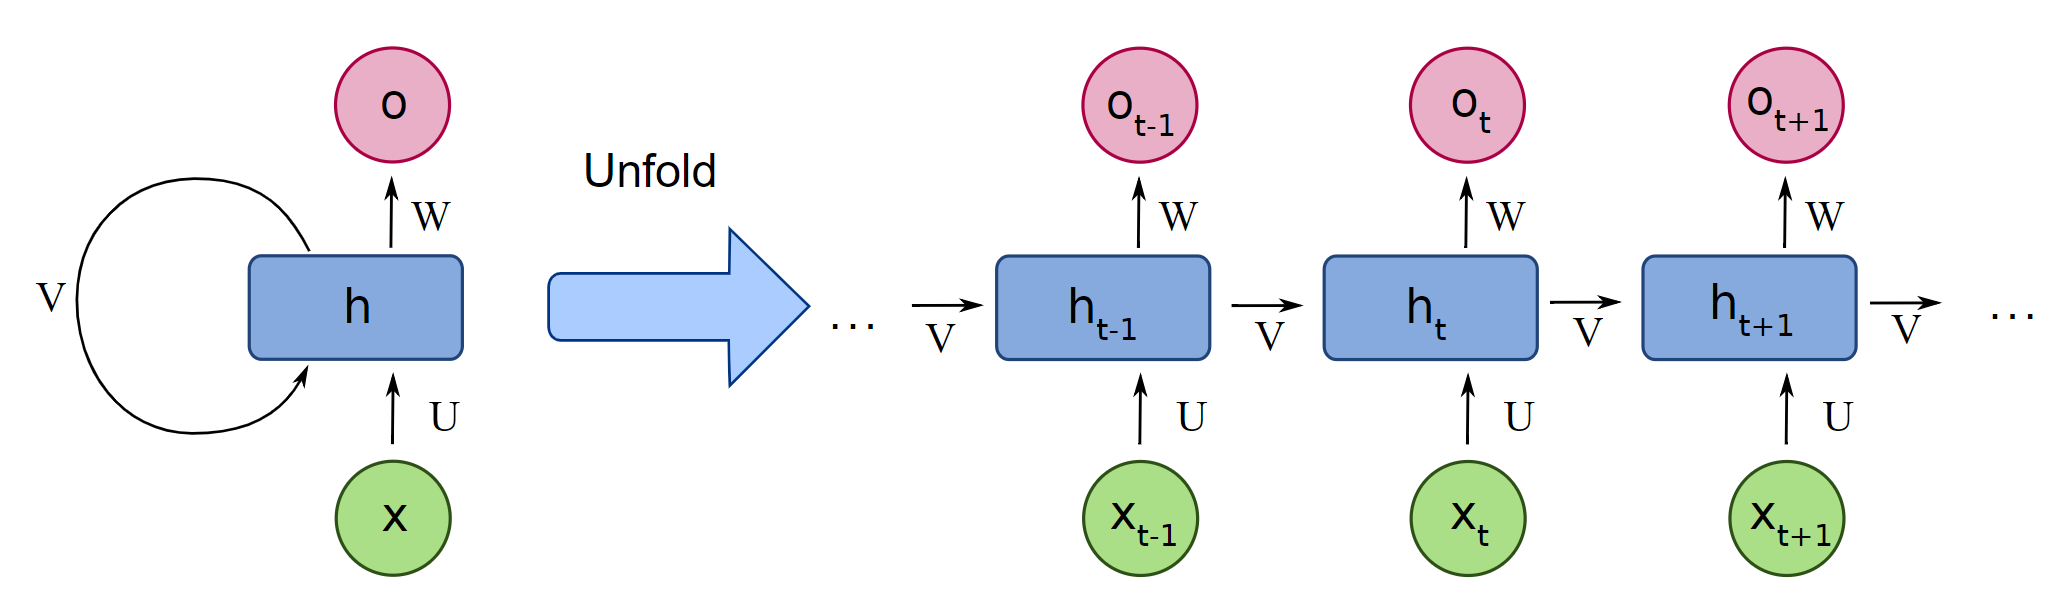

## Import RNN from torch module

In [ ]:
# number of features in hidden state
hidden_size = 10
# number of RNN layers stacked
num_layers = 1

In [ ]:
single_rnn = nn.RNN(
    input_size=input_size,     # 1 = the number of feature at each time step
    hidden_size=hidden_size,   # 10 = number of feature you want to have in neural model 
    num_layers=num_layers,     
    nonlinearity='tanh',       # activation func 
    batch_first=True,          # seq_length, batch_size, input_size when you set your model as batch_first = False 
    dropout=0,            
    bidirectional=False        # num_directions = 1
)

In [ ]:
inputs = data.view(batch_size, seq_length, input_size)

In [ ]:
inputs.shape # batchsize, seq_length, input_size

torch.Size([3, 5, 1])

In [ ]:
outputs, h_n = single_rnn(inputs)

In [ ]:
outputs.shape # bathsize, seq_length, hidden

torch.Size([3, 5, 10])

In [ ]:
prediction = # batch_size, number of classes  # multi classication prob

In [ ]:
h_n

tensor([[[-0.9801,  0.7272,  0.3233,  0.5597, -0.2662, -0.8498,  0.6366,
          -0.3814,  0.9321, -0.1735],
         [-0.9989,  0.8458,  0.6423,  0.9111, -0.2045, -0.9911,  0.8429,
          -0.6695,  0.9926, -0.6134],
         [-0.9999,  0.9081,  0.8533,  0.9866, -0.0293, -0.9995,  0.9303,
          -0.8550,  0.9990, -0.8530]]], grad_fn=<StackBackward>)

In [ ]:
h_n.shape # seq_length, batch_size, hidden_dim

torch.Size([1, 3, 10])

## Apply RNN to image classification

In [ ]:
import torchvision
import torchvision.transforms as transforms

In [ ]:
batch_size = 64

transform = transforms.Compose([
    transforms.ToTensor()
])

trainset = torchvision.datasets.MNIST(root='./mnist', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./mnist', train=False, transform=transform)

Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw


Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw


Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw




Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
from multiprocessing import cpu_count

In [ ]:
num_workers = int(cpu_count() / 2)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [ ]:
class ImageRNN(nn.Module):
    def __init__(self, batch_size, seq_length, input_size, hidden_size, num_classes, device):
        super().__init__()
        self.batch_size = batch_size
        self.seq_length = seq_length
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_classes = num_classes

        self.rnn = nn.RNN(
                            input_size=input_size,     # 28 = the number of feature at each time step
                            hidden_size=hidden_size,   # 50 = number of feature you want to have in neural model 
                            nonlinearity='tanh',       # activation func 
                            batch_first=True,          # seq_length, batch_size, input_size when you set your model as batch_first = False 
                        )
        
        self.fc = nn.Linear(seq_length * hidden_size, num_classes) # 28 * 50 1400 / 10
        
        # seq_length = 28 
        # input_size = 28
        # batch = 64
        # hidden_size = 50
        # num_classes = 10

        # image = (batch_size, channel_size, width, height)
        # image_rnn = (batch_siz, seq_length, input_size = height x channel_size)

    def forward(self, x):  # (batch_size, channel_size, width, height)
        x = x.view(-1, 28, 28)  # view is ok   
        x, hidden = self.rnn(x) # bathsize, seq_length, hidden
        x = x.reshape(-1, (self.seq_length * self.hidden_size)) # reshape used // .contiguous() 
        out = self.fc(x)        # batchsize, num_classes
        return out 

In [ ]:
# parameters
seq_length = 28
input_size = 28  # w, h 
hidden_size = 50
num_classes = 10
epochs = 10

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
import torch.optim as optim

In [ ]:
model = ImageRNN(batch_size, seq_length, input_size, hidden_size, num_classes, device).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# %%time

for epoch in range(epochs):
    # Train
    model.train()
    
    train_loss = 0
    train_correct = 0
    
    for x, y in trainloader:
        optimizer.zero_grad()

        x = x.to(device)
        y = y.to(device)
        outputs = model(x)
        loss = criterion(outputs, y)
                
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        train_correct += predicted.eq(y).sum().item()
        
    train_loss = train_loss / len(trainloader)
    train_acc = train_correct / len(trainset)
        
    print('[%2d] TRAIN loss: %.3f, acc: %.3f' % (epoch+1, train_loss, train_acc))

[ 1] TRAIN loss: 0.341, acc: 0.899
[ 2] TRAIN loss: 0.156, acc: 0.953
[ 3] TRAIN loss: 0.112, acc: 0.966
[ 4] TRAIN loss: 0.091, acc: 0.972
[ 5] TRAIN loss: 0.079, acc: 0.975
[ 6] TRAIN loss: 0.070, acc: 0.978
[ 7] TRAIN loss: 0.063, acc: 0.980
[ 8] TRAIN loss: 0.059, acc: 0.981
[ 9] TRAIN loss: 0.053, acc: 0.983
[10] TRAIN loss: 0.050, acc: 0.984


In [ ]:
# %%time

# Test
model.eval()

test_loss = 0
test_correct = 0
test_preds = []

with torch.no_grad():
    for i, (x, y) in enumerate(testloader):
        x = x.view(-1, 28, 28)
        
        x = x.to(device)
        y = y.to(device)
        outputs = model(x)
        loss = criterion(outputs, y)
        
        test_loss += loss.item()
        _, predicted = outputs.max(1)
        test_correct += predicted.eq(y).sum().item()
        
        if i == 0:
            test_preds = predicted
        else:
            test_preds = torch.cat((test_preds, predicted), dim=0)
            
test_preds = test_preds.cpu()

print('TEST loss: %.4f, acc: %.4f' % (test_loss/len(testloader), test_correct/len(testset)))

TEST loss: 0.0619, acc: 0.9800


In [ ]:
print(test_preds)

tensor([7, 2, 1,  ..., 4, 5, 6])


# Exercise1

Problem1. implement two neural network architectures as drawn below

- Use ReLU as activation function


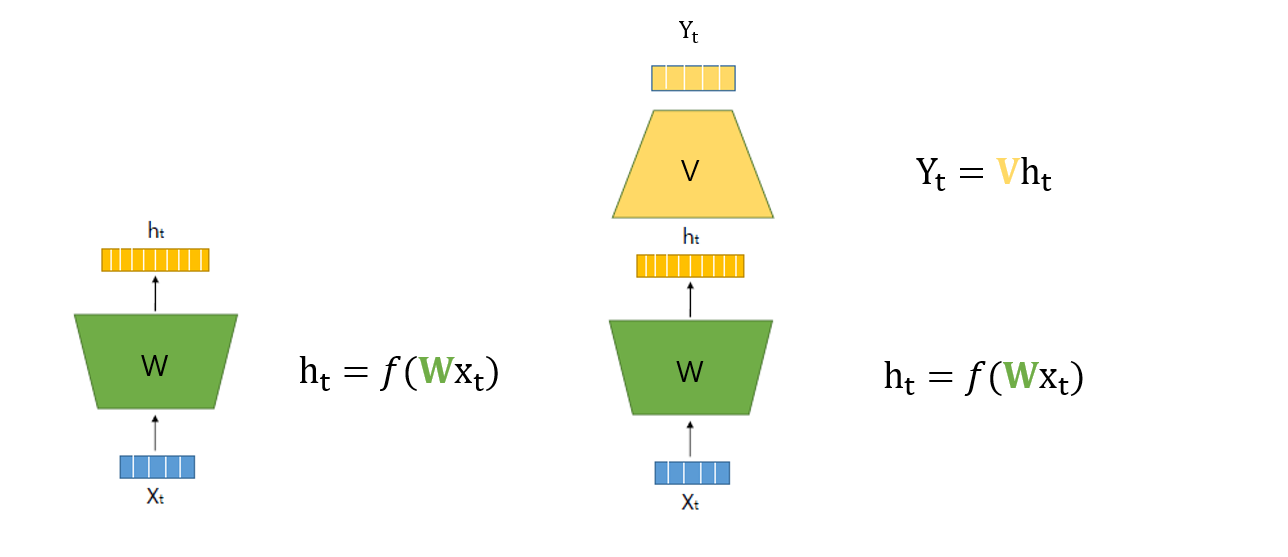

In [ ]:
class DNN_h(nn.Module):
    def __init__(self, input_dim, hid_dim): 
        super(DNN_h, self).__init__()
        self.hidden = nn.Linear(input_dim, hid_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.relu(self.hidden(x))
        return out

In [ ]:
class DNN(nn.Module):
    def __init__(self, input_dim, hid_dim, num_classes): 
        super(DNN, self).__init__()
        self.hidden = nn.Linear(input_dim, hid_dim)
        self.output = nn.Linear(hid_dim, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.hidden(x))
        out = self.output(x)
        return out

Problem2. implement recurrent neural network architecture for one step as described below

- Use tanh as activation function

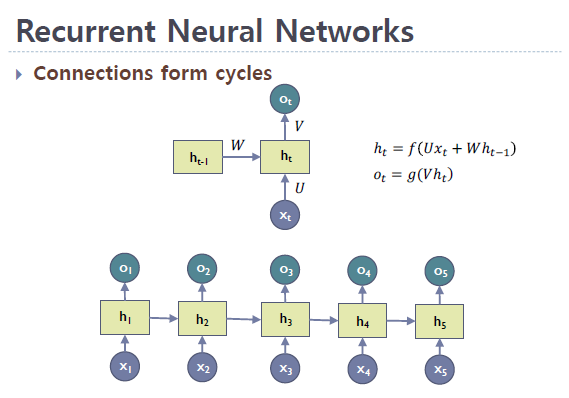

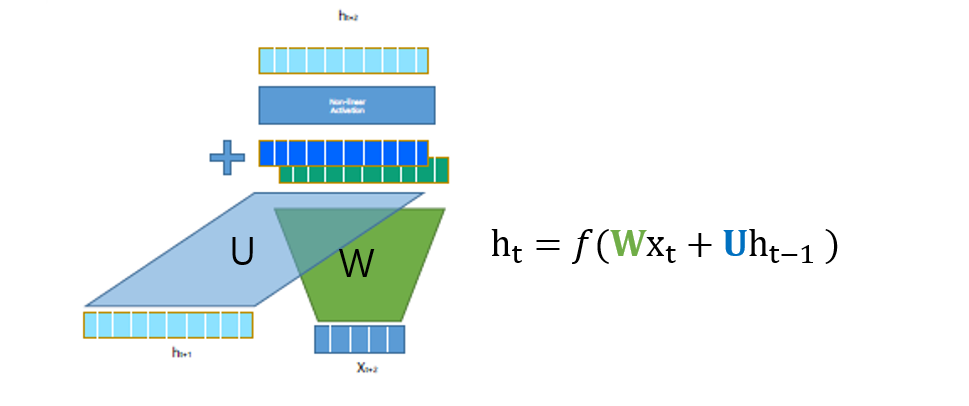

In [ ]:
class RNNstep(nn.Module):
    def __init__(self, input_dim, hid_dim): 
        super(RNNstep, self).__init__()
        self.W = nn.Linear(input_dim, hid_dim)
        self.U = nn.Linear(hid_dim, hid_dim)

        self.act = nn.Tanh()
        
    def forward(self, x, h_prev): # batch_size x (seq_length = 1) x input_dim / (seq_length,) batch_size x hidden_dim 
        h_next = self.act(self.W(x) + self.U(h_prev))
        return h_next # batch x hid dim

## Implementing Full RNN

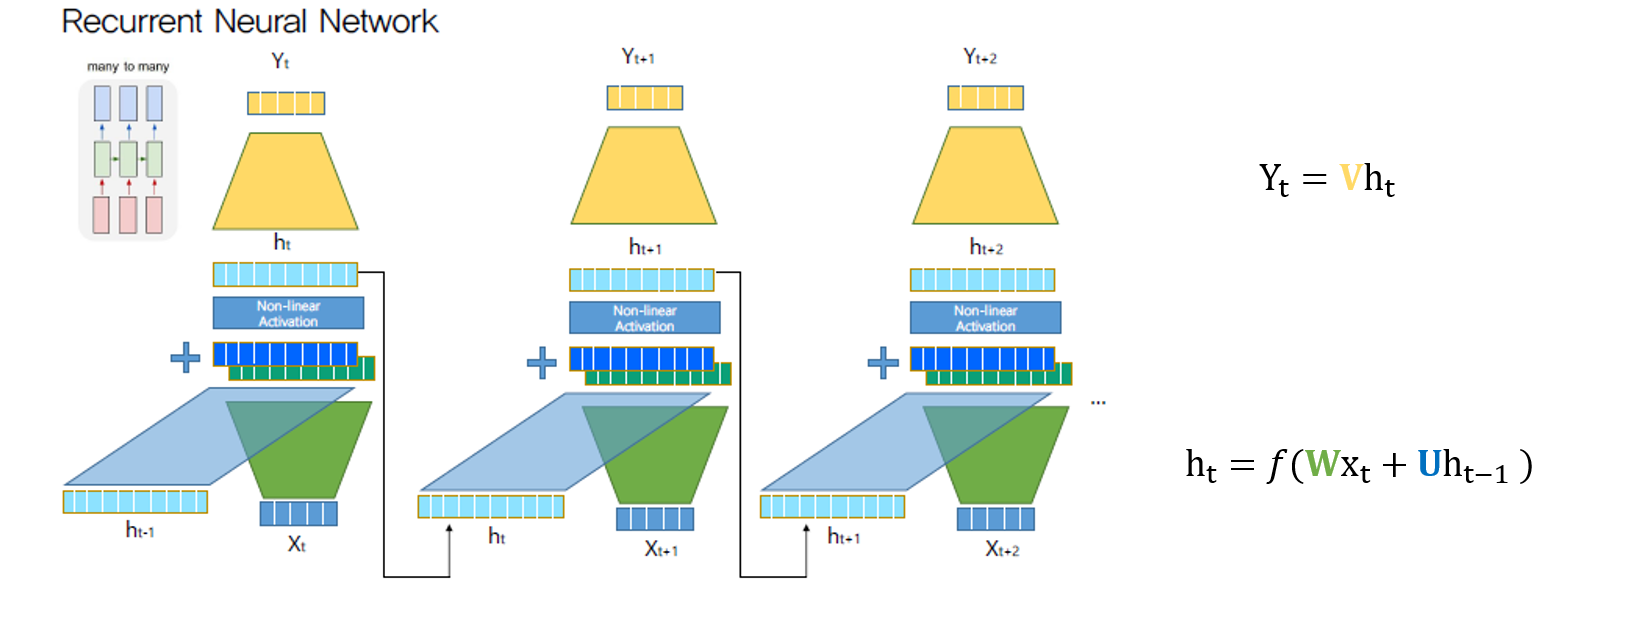

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_dim, num_classes, hid_dim, batch_size): 
        super(RNN, self).__init__()
        self.params = [input_dim, num_classes, hid_dim, batch_size]

        self.step_layer = RNNstep(self.params[0], self.params[2])
        self.V = nn.Linear(hid_dim, num_classes)

        self.h = self.init_hidden()

    def init_hidden(self):
        return torch.zeros(self.params[3], self.params[2]) # (seq_length,) batch_size x hidden_dim 

    def forward(self, xs):
        self.h = self.init_hidden() # zero initialize 
        _, seq_length, _ = xs.shape # batch x seq_len x input_dim
        
        outs = torch.zeros((self.params[3], seq_length, self.params[1]))# batch x seq len x num_classes
        hs = torch.zeros((self.params[3], seq_length, self.params[2]))# batch x seq len x hidden

        for t in range(seq_length):
            self.h = self.step_layer(xs[:,t,:], self.h)
            out = self.V(self.h) # batch x num_class

            # save output
            outs[: ,t ,:] = out
            hs[:, t, :] = self.h

        return outs, hs        

1. output layer 
2. hidden state go over time step (previous value effect next value)
3. U W V is fixed during one epoch

In [ ]:
inputs.shape # batch_size, seq_length, input_dim

torch.Size([3, 5, 1])

In [ ]:
model = RNN(1, 7, 12, 3) # input dim x num class x hid dim x batchsize

In [ ]:
outs, hs = model(inputs)

In [ ]:
outs.shape # batch x seq len x out dim (=num_classes)

torch.Size([3, 5, 7])

In [ ]:
hs.shape # batch x seq len xx hid dim 

torch.Size([3, 5, 12])

# Part2. Variations

### Stacked RNN

In [ ]:
# number of features (number of columns)
input_size = 1
# number of previous time stamps taken into account
seq_length = 5
# number of features in hidden state
hidden_size = 10
# number of RNN layers stacked
num_layers = 1

batch_size = 3

In [ ]:
stacked_rnn = nn.RNN(
    input_size=input_size,
    hidden_size=hidden_size,
    num_layers=4,
    batch_first=True
)

In [ ]:
inputs = data.view(batch_size, seq_length, input_size)

In [ ]:
outputs, h_n = stacked_rnn(inputs)

### Bi-directional RNN

In [ ]:
birnn = nn.RNN(
    input_size=input_size,
    hidden_size=hidden_size,
    num_layers=num_layers,
    batch_first=True,
    bidirectional=True    # num_directions = 2
)

In [ ]:
inputs = data.view(batch_size, seq_length, input_size)

In [ ]:
outputs, h_n = birnn(inputs)

In [ ]:
outputs_bi = outputs.view(batch_size, seq_length, 2, hidden_size)

In [ ]:
outputs_forward = outputs_bi[:,:,0,:]

In [ ]:
outputs_backward = outputs_bi[:,:,1,:]

In [ ]:
h_n_bi = h_n.view(num_layers, 2, batch_size, hidden_size)

In [ ]:
h_n_forward = h_n_bi[:,0,:,:]

In [ ]:
h_n_backward = h_n_bi[:,1,:,:]

## LSTM & GRU


Additional Reference: \
http://colah.github.io/posts/2015-08-Understanding-LSTMs/

https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21

In [ ]:
lstm = nn.LSTM(
    input_size=input_size,
    hidden_size=hidden_size,
    num_layers=num_layers,
    batch_first=True,
    dropout=0,
    bidirectional=False    # num_directions = 1
)

In [ ]:
outputs, h_n = lstm(inputs)

# Part3. Apply RNN to stock prediction

## Data preparation

In [ ]:
!wget https://raw.githubusercontent.com/deeplearningzerotoall/PyTorch/master/data-02-stock_daily.csv

--2020-11-12 11:08:40--  https://raw.githubusercontent.com/deeplearningzerotoall/PyTorch/master/data-02-stock_daily.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 36304 (35K) [text/plain]
Saving to: ‘data-02-stock_daily.csv.1’

data-02-stock_daily 100%[===================>]  35.45K  --.-KB/s    in 0s      

2020-11-12 11:08:40 (149 MB/s) - ‘data-02-stock_daily.csv.1’ saved [36304/36304]



In [ ]:
import torch
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

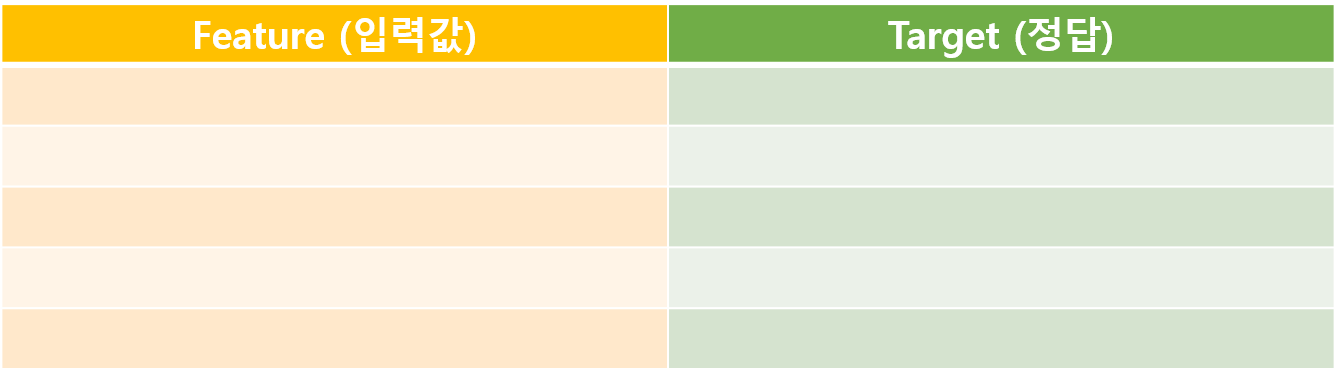

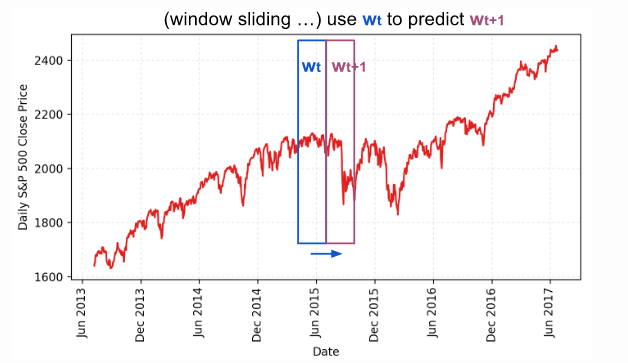

In [ ]:
# 200 time step
# seq_len = 7
# feature = 5
data = # seq len x features 7 x 5
label = # target - 1 x features 1 x 5

SyntaxError: ignored

In [ ]:
# load data
xy = np.loadtxt("data-02-stock_daily.csv", delimiter=",")
xy = xy[::-1]  # reverse order

# split train-test set
train_size = int(len(xy) * 0.7)
train_set = xy[0:train_size]
test_set = xy[train_size - seq_length:]

In [ ]:
train_set.shape

(512, 5)

In [ ]:
# make dataset to input
def build_dataset(time_series, seq_length):
    dataX = []
    dataY = []
    for i in range(0, len(time_series) - seq_length):
        _x = time_series[i:i + seq_length, :]
        _y = time_series[i + seq_length, [-1]]  # Next close price
        # print(_x, "->", _y)
        dataX.append(_x)
        dataY.append(_y)
    return np.array(dataX), np.array(dataY)

In [ ]:
# scaling function for input data
def minmax_scaler(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    return numerator / (denominator + 1e-7)

In [ ]:
# scaling data
train_set = minmax_scaler(train_set)
test_set = minmax_scaler(test_set)

# make train-test dataset to input
trainX, trainY = build_dataset(train_set, seq_length)
testX, testY = build_dataset(test_set, seq_length)

# convert to tensor
trainX_tensor = torch.FloatTensor(trainX)
trainY_tensor = torch.FloatTensor(trainY)

testX_tensor = torch.FloatTensor(testX)
testY_tensor = torch.FloatTensor(testY)

## Model

In [ ]:
# hyper parameters
seq_length = 7
data_dim = 5    # number of features
hidden_dim = 10 # 
output_dim = 1  # num_classes
learning_rate = 0.01  # 
iterations = 500

In [ ]:
class simpleLSTM(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, layers):
        super(simpleLSTM, self).__init__()
        self.rnn = torch.nn.LSTM(input_dim, hidden_dim, num_layers=layers, batch_first=True)
        self.fc = torch.nn.Linear(hidden_dim, output_dim, bias=True)

    def forward(self, x):
        x, _status = self.rnn(x)
        x = self.fc(x[:, -1])
        return x

model = simpleLSTM(data_dim, hidden_dim, output_dim, 1)

In [ ]:
# loss & optimizer setting
criterion = torch.nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# start training
for i in range(iterations):

    optimizer.zero_grad()
    outputs = model(trainX_tensor)
    loss = criterion(outputs, trainY_tensor)
    loss.backward()
    optimizer.step()
    print(i, loss.item())

In [ ]:
testY.shape

(220, 1)

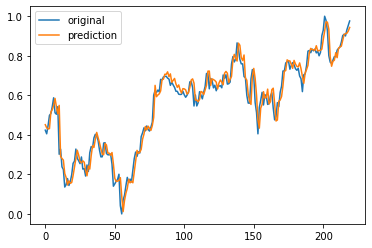

In [ ]:
plt.plot(testY)
plt.plot(model(testX_tensor).data.numpy())
plt.legend(['original', 'prediction'])
plt.show()

# Exercise2

Quiz1 

Answer a True/False question.

- In feed-forward step in RNN, we use same parameters$(W, U, V)$ at each time step$(0, 1, 2, ..., t)$ to generate hidden states$(h_0, h_1, ... , h_t)$


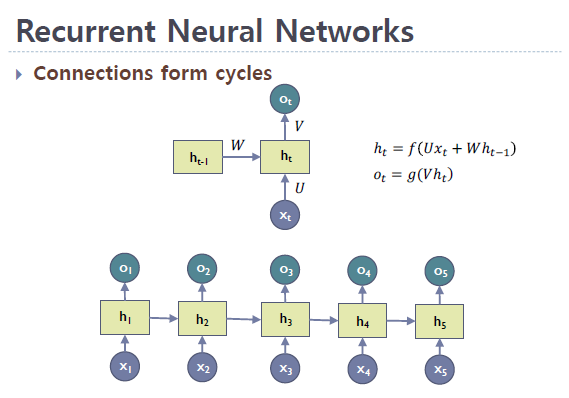

In [ ]:
answer_prob1 = # boolean

Quiz2

Let's say you initialize RNN with this code. Select the appropriate shape of input_data among options below.

```
rnn = torch.nn.RNN(input_size = input_dim,
                   hidden_size = hid_dim,
                   batch_first = False)
                   
output, hidden_state = rnn(input_data)
```



In [ ]:
option_1 = (seq_length, batch_size, hid_dim)
option_2 = (batch_size, hid_dim, seq_length)
option_3 = (batch_size, seq_length, input_dim)
option_4 = (seq_length, input_dim, hid_dim)

answer_prob2 = # number of your choice